<a href="https://colab.research.google.com/github/LiuWL-stu/DIP/blob/main/SEIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
import numpy as np
import math
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [85]:
# === 数据准备 ===
read = np.array([8048951, 577559, 223872, 189400])
fw = np.array([1145, 375, 23, 62])
com = np.array([1097, 294, 18, 61])
like = np.array([16689, 6771, 78, 822])
I_raw = fw + com + like
R_raw = read - I_raw

# SEIR的量化
E_obs = read - I_raw
S_obs = 10000000 - np.cumsum(read)
I_obs = I_raw
R_obs = np.cumsum(R_raw)

# NorTP 和 TI
search_volume = np.array([150000, 80000, 20000, 10000])
discussion_volume = fw + com
spread_volume = read
interaction_volume = I_raw
raw_interaction_rate = interaction_volume / (spread_volume + 1e-8)
interaction_rate = 1 + 0.2 * (raw_interaction_rate - raw_interaction_rate.min()) / (raw_interaction_rate.max() - raw_interaction_rate.min() + 1e-8)
weibo_heat = (search_volume + discussion_volume + spread_volume) * interaction_rate
NorTP = (weibo_heat - np.min(weibo_heat)) / (np.max(weibo_heat) - np.min(weibo_heat) + 1e-8)
TI = np.array([0.0785] * 4)

# === STEP 2: 修改后的损失函数，使用 alpha * NorTP ===
def loss_alphaTP(params):
    alpha, beta, gamma = params
    loss_val = 0
    for t in range(len(S_obs) - 1):
        tp = alpha * NorTP[t]
        ti = TI[t]


        dS = -alpha * ti * S_obs[t] * E_obs[t]
        dE = alpha * ti * S_obs[t] * E_obs[t] - beta * E_obs[t] - gamma * E_obs[t]

        dI = gamma * E_obs[t] - tp * I_obs[t]
        dR = beta * E_obs[t] + tp * I_obs[t]

        pred_S = S_obs[t] + dS
        pred_E = E_obs[t] + dE
        pred_I = I_obs[t] + dI
        pred_R = R_obs[t] + dR

        loss_val += (S_obs[t + 1] - pred_S) ** 2
        loss_val += (E_obs[t + 1] - pred_E) ** 2
        loss_val += (I_obs[t + 1] - pred_I) ** 2
        loss_val += (R_obs[t + 1] - pred_R) ** 2


    return loss_val

# 拟合参数
def fit_model_alphaTP():
    result = minimize(loss_alphaTP, x0=[0.01, 0.3, 0.2], bounds=[(0, 1), (0, 1), (0, 1)])
    return result.x

# === 拟合并预测 ===
alpha_est, beta_est, gamma_est = fit_model_alphaTP()
E_real = E_obs
S_real = S_obs
TI_real = TI
F_real = np.array([1.0] * len(E_real))
TP_real = alpha_est * NorTP

E_pred = [E_real[0]]
for t in range(len(E_real) - 1):
    E_t = E_pred[t]
    S_t = S_real[t]
    TI_t = TI_real[t]
    F_t = F_real[t]
    dE = alpha_est * TI_t * S_t * E_t - beta_est * TI_t * E_t - gamma_est * F_t * E_t
    E_pred.append(E_t + dE)
E_pred = np.array(E_pred)

# 误差指标
mse = mean_squared_error(E_real, E_pred)
mae = mean_absolute_error(E_real, E_pred)
r2 = r2_score(E_real, E_pred)

In [225]:
# === 数据准备 ===
read = np.array([8048951, 577559, 223872, 189400])
fw = np.array([1145, 375, 23, 62])
com = np.array([1097, 294, 18, 61])
like = np.array([16689, 6771, 78, 822])
I_raw = fw + com + like
R_raw = read - I_raw

# SEIR的量化
E_obs = read - I_raw
S_obs = 10000000 - np.cumsum(read)
I_obs = I_raw
R_obs = np.cumsum(R_raw)

# NorTP 和 TI
search_volume = np.array([150000, 80000, 20000, 10000])
discussion_volume = fw + com
spread_volume = read
interaction_volume = I_raw
raw_interaction_rate = interaction_volume / (spread_volume + 1e-8)
interaction_rate = 1 + 0.2 * (raw_interaction_rate - raw_interaction_rate.min()) / (raw_interaction_rate.max() - raw_interaction_rate.min() + 1e-8)
weibo_heat = (search_volume + discussion_volume + spread_volume) * interaction_rate
NorTP = (weibo_heat - np.min(weibo_heat)) / (np.max(weibo_heat) - np.min(weibo_heat) + 1e-8)
TI = np.array([0.0785] * 4)


In [233]:

# 设定暴降事件的时间点 t_shock 和暴降的幅度
t_shock = 0  # 假设暴降发生在第 2 个时间点
shock_magnitude = 1  # 暴降幅度，例如减少暴露者数的 50%

# 定义冲击函数
def shock_effect(t, E_t):
    if t == t_shock:
        return E_t * shock_magnitude  # 在 t_shock 时进行暴降
    return E_t  # 否则不变化

# === STEP 2: 修改后的损失函数，使用 alpha * NorTP ===
def loss_alphaTP(params):
    alpha, beta, gamma,FI = params
    a = 1 / (1 + np.exp(-alpha))
    loss_val = 0
    for t in range(len(S_obs) - 1):
        tp = alpha * NorTP[t]
        ti = TI[t]


        dS = -alpha * ti * S_obs[t] * E_obs[t]
        dE = alpha * S_obs[t] * E_obs[t] - ti*beta * E_obs[t] - FI*gamma * E_obs[t]

        dI = FI*gamma * E_obs[t] - tp * I_obs[t]
        dR = beta *ti* E_obs[t] + tp * I_obs[t]

        pred_S = S_obs[t] + dS
        pred_E = E_obs[t] + dE
        pred_I = I_obs[t] + dI
        pred_R = R_obs[t] + dR

        loss_val += (S_obs[t + 1] - pred_S) ** 2
        loss_val += (E_obs[t + 1] - pred_E) ** 2
        loss_val += (I_obs[t + 1] - pred_I) ** 2
        loss_val += (R_obs[t + 1] - pred_R) ** 2


    return loss_val

# 拟合参数
def fit_model_alphaTP():
    result = minimize(loss_alphaTP, x0=[0.01, 0.3, 0.2,1], bounds=[(None,None), (0, 1), (0, 1),(None,None)])
    return result.x



In [261]:
# === 拟合并预测 ===
alpha_est, beta_est, gamma_est,FI = fit_model_alphaTP()
E_real = E_obs
S_real = S_obs
TI_real = TI
#F_real = np.array([1.0] * len(E_real))
TP_real = alpha_est * NorTP

E_pred = [E_real[0]]
for t in range(len(E_real) - 1):
    E_t = E_pred[t]
    S_t = S_real[t]
    TI_t = TI_real[t]
    #F_t = F_real[t]
    #FI=F_real[t]
    #dE = alpha_est * S_t * E_t - beta_est * TI_t * E_t - gamma_est * F_t * E_t*FI
    dE = alpha_est * S_t * E_t - beta_est * TI_t * E_t - gamma_est * F_t * E_t*0.5
     # 应用暴降影响
    E_t_new = E_t + dE
    E_t_new = shock_effect(t, E_t_new)  # 调用冲击函数
    E_pred.append(E_t_new)
    #E_pred.append(E_t + dE)
E_pred = np.array(E_pred)



# 误差指标
mse = mean_squared_error(E_real, E_pred)
mae = mean_absolute_error(E_real, E_pred)
r2 = r2_score(E_real, E_pred)

<ipython-input-233-9f52f85982de>:14: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-alpha))


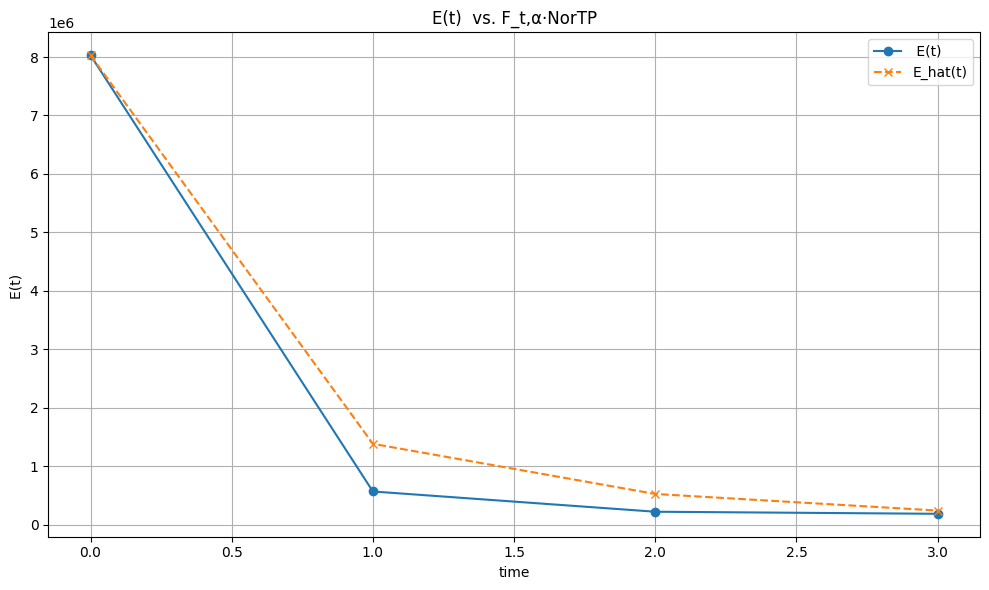

((np.float64(-3.608065822779949e-07), np.float64(0.3), np.float64(0.2)),
 (189914842778.81564, 293499.8046341592, 0.9829620213328917))

In [262]:
# 可视化
plt.figure(figsize=(10, 6))
plt.plot(E_obs, label=' E(t)', marker='o')
plt.plot(E_pred, label='E_hat(t)', linestyle='--', marker='x')
plt.title("E(t)  vs. F_t,α·NorTP")
plt.xlabel("time")
plt.ylabel("E(t) ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(alpha_est, beta_est, gamma_est), (mse, mae, r2)

In [263]:
a = 1 / (1 + np.exp(-alpha_est))
print(a)

0.49999990979835435
